# BTTH07: Quá khớp (Overfitting)


#Trần Tuấn Tú - 1312681
---



## 1. Cách làm bài và nộp bài

**Làm bài**

Bạn sẽ làm trực tiếp trên file notebook này; trong file, mình đã để từ `TODO` để cho biết những chỗ mà bạn cần phải làm (trong đó, `TODO` đầu tiên là bạn phải ghi họ tên và MSSV vào phần đầu của file). Trong khi làm bài, thường xuyên `Ctrl + S` để lưu lại bài làm của bạn, tránh mất mát thông tin.

*Lưu ý: tuyệt đối không gian lận. Nếu vi phạm thì bạn sẽ bị 0 điểm cho cả phần thực hành môn học. Nên nhớ mục tiêu chính ở đây là học kiến thức.*

**Nộp bài**

Khi chấm bài, đầu tiên mình sẽ chọn `Cell` - `Run All` để chạy tất cả các cell trong notebook của bạn; do đó, trước khi nộp bài, bạn nên chạy thử `Cell` - `Run All` để đảm bảo mọi chuyện diễn ra đúng như mong đợi.

Sau đó, trong thư mục `MSSV` (vd, nếu bạn có MSSV là 1234567 thì bạn đặt tên thư mục là `1234567`) bạn đặt file `Ex07-Overfitting.ipynb`; rồi nén thư mục `MSSV` này lại và nộp ở link trên moodle.

## 2. Import

In [562]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
# You can also import other things ...

## 3. Hàm phát sinh dữ liệu

Trong bài tập này, bạn sẽ thử nghiệm Neural Net trên bộ dữ liệu tự tạo với không gian đầu vào $\mathcal{X}$ là không gian một chiều (để có thể trực quan hóa được). Cách tạo bộ dữ liệu như sau:

- Hàm đích (target function) của mình là: $f(x) = x$.
- Mỗi input $x$ được phát sinh bằng cách lấy ngẫu nhiên một giá trị trong $[-1, 1]$ theo phân bố đều. Output $y$ tương ứng sẽ được phát sinh như sau: $y = f(x) + noise$ với $noise$ được phát sinh từ phân bố Gauss với mean bằng 0 và variance bằng $0.3^2$.

In [563]:
def generate_data(N):
    """
    Generates data.
    
    Parameters
    ----------
    N : int
        The number of data points.
    
    Returns
    -------
    (X, Y) : tuple
        X : numpy array, shape (N, 2)
            The matrix of input vectors (each row corresponds to an input vector); the first column of 
            this matrix is all ones (corresponding to x_0).
        Y : numpy array, shape (N, 1)
            The vector of outputs.
    """
    X = np.ones((N, 2))
    for i in range(N):
         X[i, 1] = np.random.uniform(-1,1)
    Y = X[:, 1:2]
    Y = Y + np.array([np.random.normal(0,0.3,N)]).T
    return (X, Y)
    # TODO

Kế đến, bạn sẽ định nghĩa các hàm của Neural Net cho dữ liệu này. Các hàm này không có gì thay đổi so với tuần trước, ngoại trừ:

- Do ta đang giải quyết bài toán hồi qui nên tầng Softmax sẽ được thay bằng tầng Linear Regression; và hàm chi phí Mean Negative Log Likelihood sẽ được thay bằng hàm Mean Squared Error.
- Ở hàm `train_neural_net`, có bổ sung các tham số đầu vào và các kết quả trả về; cụ thể bạn đọc ở phần mô tả hàm bên dưới.

## 4. Hàm lan truyền tiến qua Neural Net

Trong bài này, ta sẽ sử dụng nơ-ron sigmoid ở các tẩng ẩn, và tầng cuối là tầng Linear Regression (sử dụng hàm kích hoạt $\theta(z)=z$).

In [564]:
def sigmoid(Z):
    """
    Computes sigmoid function for each element of numpy array Z.
    """
    return 1 / (1 + np.exp(-Z))

def forward_prop(X, Ws):
    """
    Forward propagates X through layers of neural nets to get the final outputs.
    
    Parameters
    ----------
    X : numpy array, shape (N, d+1)
        The matrix of input vectors (each row corresponds to an input vector); the first column of 
        this matrix is all ones (corresponding to x_0).
    Ws : list of numpy arrays
        The list of each layer's W; W of layer l will have the shape of (d^(l-1)+1, d^(l)) where 
        d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1, and 
        d^(l) is the number of neurons (not count the +1 neuron) of layer l.
    
    Returns
    -------
    A : numpy array, shape (N, 1)
        The vector of Neural Net's outputs.
    """
    A = X
    for i in range(len(Ws)):
        Z = A.dot(Ws[i])
        if i == len(Ws) - 1:
            A = Z
        else:
            A = sigmoid(Z)
            A = np.hstack((np.ones((A.shape[0],1)), A))
    return A
    # TODO

## 5. Hàm huấn luyện Neural Net

In [565]:
def train_neural_net(X, Y, X_val, Y_val, layer_sizes, learning_rate, mnb_size, max_epoch):
    """
    Trains Neural Net on the dataset (X, Y).
    Cost function: Mean Squared Error (MSE).
    Optimization algorithm: Stochastic Gradient Descent (SGD).
    
    Your code needs to print out the MSE on the training set and validation set (it's a data set 
    different from the training set and used to estimate E_out) after each 1000-epochs (in this 
    exercise, we are going to use a pretty big `max_epoch`; so, we'll not want to print after each
    epoch).
    (E.g., 'Epoch ..., training err ..., val err ...')
    
    Parameters
    ----------
    X : numpy array, shape (N, d + 1)
        The matrix of input vectors (each row corresponds to an input vector) of the training set; 
        the first column of this matrix is all ones (corresponding to x_0).
    Y : numpy array, shape (N, 1)
        The vector of outputs of the training set.
    X_val : numpy array, shape (N_val, d + 1)
        The matrix of input vectors (each row corresponds to an input vector) of the validation set; 
        the first column of this matrix is all ones (corresponding to x_0).
    Y_val : numpy array, shape (N_val, 1)
        The vector of outputs of the validation set.  
    layer_sizes : list of ints
        The list of each layer' size (not count the +1 neurons).
        E.g. layer_sizes = [784, 30, 10] means: the 1st layer (input layer) has 784 neurons,
        the 2nd layer (hidden layer) has 30 neurons, the 3rd layer (output layer) has 10 neurons.
    learning_rate : float
        Learning rate of SGD.
    mnb_size : int
        Minibatch size of SGD.
    max_epoch : int
        After this number of epochs, we'll terminate SGD.
    
    Returns
    -------
    (best_Ws, Ws, E_ins, E_outs) : tuple
        best_Ws : list of numpy arrays
            The list of each layer's W; W of layer l will have the shape of (d^(l-1)+1, d^(l)) where 
            d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1, and 
            d^(l) is the number of neurons (not count the +1 neuron) of layer l.
            It's the parameters having smallest error on the validation set.
        Ws : list of numpy arrays
            The list of each layer's W; W of layer l will have the shape of (d^(l-1)+1, d^(l)) where 
            d^(l-1) is the number of neurons (not count the +1 neuron) of layer l-1, and 
            d^(l) is the number of neurons (not count the +1 neuron) of layer l.
            It's the parameters after `max_epoch` epochs.
        E_ins: list of floats
            List of E_in's (MSE on the training set) after each 1000-epochs; len(E_ins)=max_epoch/1000.
        E_outs: list of floats
            List of E_out's (MSE on the validation set) after each 1000-epochs; len(E_outs)=max_epoch/1000.
    """
    # Init weights
    Ws = [np.random.randn(layer_sizes[l]+1, layer_sizes[l+1]) / np.sqrt(layer_sizes[l]+1) for l in range(len(layer_sizes)-1)]
    best_Ws_list = []
    E_ins = []
    E_outs = []
    # TODO
    N = X.shape[0]
    rand_idxs = range(N)
    #one_hot_Y = np.zeros((N,10))
    #for i in range(N):
    #    one_hot_Y[i][Y[i]] = 1
    for epoch in range(max_epoch):
        np.random.shuffle(rand_idxs)
        for start_idx in range(0, N, mnb_size):
            mnb_X = X[rand_idxs[start_idx:start_idx + mnb_size]]
            mnb_Y = Y[rand_idxs[start_idx:start_idx + mnb_size]]
            #forward prop
            As = [mnb_X]
            A = mnb_X
            for i in range(len(Ws)):
                Z = A.dot(Ws[i])
                if i == len(Ws) - 1:
                    A = Z
                else:
                    A = sigmoid(Z)
                    A = np.hstack((np.ones((A.shape[0],1)), A))
                As.append(A)
            #back prop
            delta = As[-1] - mnb_Y
            grad = As[-2].T.dot(delta) / mnb_size
            Ws[-1] -= learning_rate * grad
            for l in range(2, len(layer_sizes)):
                if (l >= 3):                
                    delta = delta[:,1:].dot(Ws[-l+1].T) * As[-l] * (1 - As[-l]) #Trường hợp nhiều hơn 3 layer, bỏ đi cột đầu 
                else:
                    delta = delta.dot(Ws[-l+1].T) * As[-l] * (1 - As[-l]) #Trường hợp từ 3 layer trở xuống
                grad = As[-l-1].T.dot(delta[:, 1:]) / mnb_size    
                Ws[-l] -= learning_rate * grad
        if ((epoch + 1) % 1000 == 0):
            A = forward_prop(X, Ws)
            res = np.square(A - Y)
            E_in = (np.sum(res, axis=0))/(X.shape[0])
            E_ins.append(E_in)
    
            B = forward_prop(X_val, Ws)
            res = np.square(B - Y_val)
            E_out = (np.sum(res, axis=0))/(X_val.shape[0])
            E_outs.append(E_out)
            best_Ws_list.append(copy.deepcopy(Ws))
    
    best_Ws  = best_Ws_list[np.argmin(E_outs)]
    return (best_Ws, Ws, E_ins, E_outs)

## 6. Chạy

Bây giờ, bạn sẽ dùng các hàm đã định nghĩa ở trên như sau:

1. Phát sinh ra tập huấn luyện gồm 5 điểm dữ liệu, và tập validation gồm 1000 điểm dữ liệu.
2. Huấn luyện Neural Net với `layer_sizes = [1, 10, 1]`. Chạy SGD với `learning_rate = 0.1`, `mnb_size = 5`, và `max_epoch = 50000`.
3. Vẽ hai đồ thị:

    - Đồ thị 1: trục hoành là số lượng epoch, trục tung là độ lỗi; trên đồ thị này, vẽ ra hai đường ứng với E_in (độ lỗi trên tập train) và E_out (độ lỗi trên tập validation) sau mỗi 1000-epoch.
    - Đồ thị 2: trục hoành là input x, trục tung là output y; trên đồ thị này, vẽ ra: đường đích $y = x$, các điểm dữ liệu của tập huấn luyện, hai đường hồi qui ứng với `best_Ws` và `Ws`. 

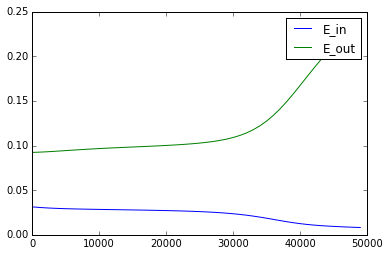

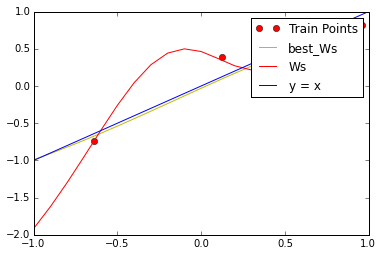

In [566]:
# TODO
X, Y = generate_data(5)
X_val, Y_val = generate_data(1000)
layer_sizes = [1, 10, 1]
best_Ws, Ws, E_ins, E_outs = train_neural_net(X, Y, X_val, Y_val, layer_sizes, 0.1, 5, 50000)

NumEpochs = []
for i in range(50):
    NumEpochs.append(i * 1000)
plt.plot(NumEpochs, E_ins, label = 'E_in')
plt.plot(NumEpochs, E_outs, label = 'E_out', color = 'g')
plt.legend()
#plt.show()

plt.figure(2)
plt.plot(X.T[1], Y.T[0], 'ro', label = 'Train Points')
X = np.ones((20, 2))
X[:, 1] = np.arange(-1, 1, 0.1)
B = forward_prop(X, Ws)
A = forward_prop(X, best_Ws)
plt.plot(X[:,1], A, label = 'best_Ws', color = 'y')
plt.plot(X[:,1], B, label = 'Ws', color = 'r')
plt.plot([1,-1], [1,-1], label = 'y = x')
plt.legend()
plt.show()

Khi epoch quá lớn, sẽ dẫn đến tình trạng quá khớp và sau đó kết quả thử trên tập Validate sẽ ngày càng sai lệch. Ban đầu, cả hai độ lỗi E_in (trên tập train) và E_out (trên tập validate) giảm, nhưng khi max_epoch quá lớn, độ lỗi E_out trên tập Validate sẽ tăng dần, độ lỗi E_in trên tập train sẽ giảm dần. Ta gọi đó là hiện tượng Overfitting (Quá khớp) trong Machine Learning, hiện tượng Overfitting diễn ra khi mô hình học bắt đầu "Ghi nhớ" tập train thay vì "Học" từ tập train. Kể từ đó, khi kết quả học được áp dụng lên tập train thì rất chính xác nhưng với dữ liệu ẩn nằm ngoài tập train, kết quả sẽ không còn chính xác và không hiệu quả. Vì thế ta cần có một điểm dừng hợp lí.